<a href="https://colab.research.google.com/github/mingshey/python_wave/blob/main/Wave2d_Double_Slit_Interference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2차원 파동

## 패키지

In [ ]:
# 필요한 라이브러리를 임포트합니다.
# numpy는 수치 계산을 위해, matplotlib.pyplot은 그래프를 그리기 위해 사용됩니다.
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# scipy.ndimage 라이브러리의 convolve (합성곱) 및 create_binary_structure 함수를 사용합니다.
import scipy.ndimage as scn

In [ ]:
# 애니메이션 제작을 위한 matplotlib.animation 라이브러리를 임포트합니다.
from matplotlib.animation import PillowWriter
import matplotlib.animation as anim

## Convolution(합성곱)이란?

In [ ]:
'''
주변 값과의 차이를 계산하는 부분은 합성곱으로 처리하기 위해

0  1  0
1 -4  1
0  1  0

모양의 커널을 이용한다.
'''

# 2차원 구조를 갖는 커널을 생성합니다.
kern = scn.generate_binary_structure(2,0).astype(int)
# 커널의 중앙 값을 -4로 설정합니다.
kern[1,1] = -4
# 생성된 커널을 출력하여 확인합니다.
print(kern)

[[ 0  1  0]
 [ 1 -4  1]
 [ 0  1  0]]


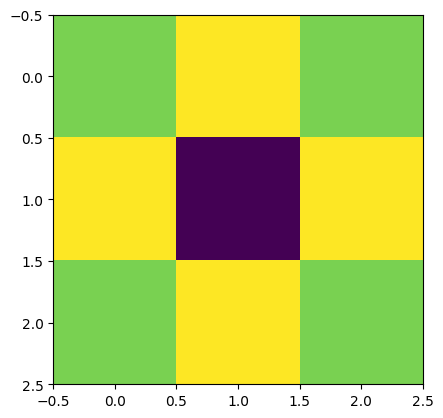

In [ ]:
# 생성된 커널을 이미지로 시각화합니다.
plt.imshow(kern)

## 함수 정의 및 초기 상태

In [ ]:
def fdm_step(past, curr, med, rows, cols, tval):
  """
  유한차분법(Finite Differnce Method)에 의해 2차원 파동방정식을 적용하여
  2차원 파동의 진행을 1 time step 씩 진행한다.
  필요한 경우 강제 진동 식을 마지막에 추가한다.
  """
  global kern, dt
  # 유한차분법을 적용하여 다음 시간 스텝에서의 값을 계산합니다.
  # scn.convolve 함수를 사용하여 합성곱을 수행합니다.
  fut = 2 * curr - past + scn.convolve(med * curr, kern)

  """
  forced oscillation
  """
  # 특정 위치(여기서는 좌측 경계)에 강제 진동을 적용합니다.
  fut[:, 0 : 2] = 10.0 * np.sin(2*np.pi*freq*tval)

  # 시간을 다음 스텝으로 업데이트합니다.
  tval = tval + dt

  # 업데이트된 과거, 현재 값과 시간을 반환합니다.
  return ([curr, fut, tval])

In [ ]:
"""
가로 세로 격자 수 설정:
"""
rs = 128 # 행(세로) 격자 수
cs = 128 # 열(가로) 격자 수

speed = 331         # 공기중 파동의 속력: [m/s]
wl = 0.08       # 파장 [m]
freq = speed / wl   # 강제진동 주파수 [Hz] (속력 / 파장)
dt = 1.0e-6     # 시뮬레이션 시간 간격 [s])
dx = 0.01       # 격자 간격 [m])
cspeed = dx/dt  # Courant condition 확인을 위한 값 (격자 간격 / 시간 간격)

In [ ]:
# 격벽을 그리는 함수를 정의합니다.
def draw_barrier(axis, c='w', lw=1):
  # 매질의 등고선을 그려 격벽을 시각화합니다.
  axis.contour(mc, [mc_mid], colors=c, linewidths=lw)

# 매질의 성질을 설정합니다:
mc = np.ones((rs, cs)) * speed    # 배경 매질의 속력을 설정합니다.

# 격벽 두께
wallw = 2
# 격벽 위치
wallp = cs//8
# 슬릿 위치
slit1 = rs//2 - rs//10
slit2 = rs//2 + rs//10
# 슬릿 폭
slitw = 2
# 벽과 슬릿을 매질에 설정합니다. 속력을 0으로 만들어 파동이 통과하지 못하게 합니다.
mc[:, wallp-wallw:wallp+wallw] = 0
# 슬릿 부분은 속력을 유지하여 파동이 통과할 수 있게 합니다.
mc[slit1-slitw:slit1+slitw, wallp-wallw:wallp+wallw] = speed
mc[slit2-slitw:slit2+slitw, wallp-wallw:wallp+wallw] = speed

# 매질의 최소, 최대 값을 계산하여 중간 값을 구합니다. (격벽 시각화에 사용)
mc_min, mc_max, foo, bar = scn.extrema(mc)
mc_mid = (mc_min+mc_max)/2

# 파동 방정식 계산에 사용될 매질 속력의 제곱 값을 계산합니다. (Courant condition 관련)
msq = (mc / cspeed) ** 2

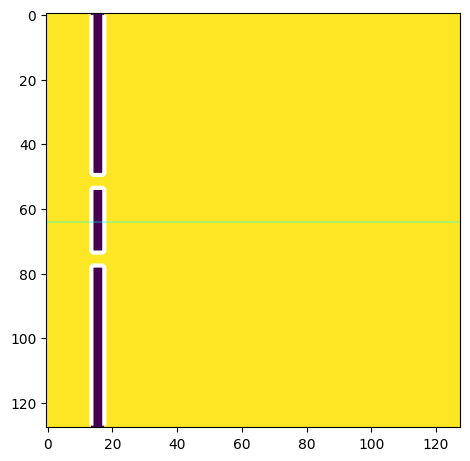

In [ ]:
# 매질 상태를 시각화하는 그래프를 생성합니다.
fig, ax = plt.subplots(1,1,figsize=(10,4.5), constrained_layout=True)
# 매질 속력 분포를 이미지로 표시합니다.
plt.imshow(mc)
# 격벽을 그립니다.
draw_barrier(ax, lw=3)
# 중앙 라인을 표시합니다.
plt.axhline(rs//2, c='cyan', alpha=0.3)

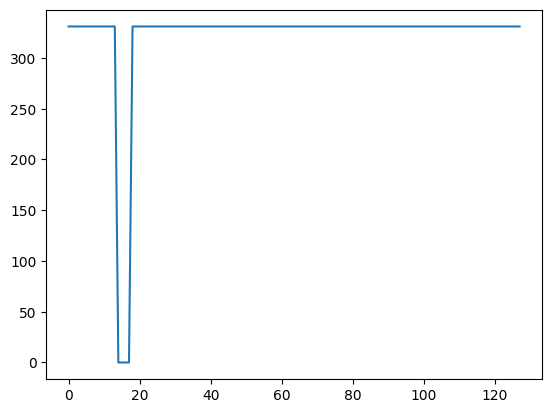

In [ ]:
# 매질의 특정 행(중앙)의 속력 분포를 그래프로 표시합니다.
plt.plot(mc[rs//2])

In [ ]:
# 파동이 없는 평형 상태로 배경을 설정합니다.
pm = np.zeros((rs, cs))  # past values 과거의 값
cm = np.zeros((rs, cs))  # current values 현재의 값

# 점 펄스 파원을 설정하는 부분 (현재는 주석 처리됨):
#pm[rs//2-2:rs//2+2, 1:3] = 100.0
#cm[rs//2-2:rs//2+2, 1:3] = 100.0

# 시간 초기화
t = 0.0

## 시뮬레이션 진행

In [ ]:
# 시뮬레이션을 진행하며 advance 개 시간 간격마다 장면 이미지를 저장합니다.
N = 5000 # 총 시뮬레이션 스텝 수
advance = 25  # 이미지 저장 간격
n = N//advance # 저장될 이미지의 총 개수

ts = np.array([]) # 시간 값을 저장할 배열
maps = np.array([]) # 시뮬레이션 결과(파동 상태)를 저장할 배열

# 시뮬레이션 루프
for k in range(n):
  # advance 스텝만큼 시뮬레이션을 진행합니다.
  for i in range(advance):
    # fdmstep 함수를 호출하여 파동을 한 스텝 진행시킵니다.
    pm, cm, t = fdm_step(pm, cm, msq, rs, cs, t)
  # advance 스텝 진행 후 현재 파동 상태를 maps 배열에 추가합니다.
  maps = np.append(maps, cm)
  # 현재 시간 값을 ts 배열에 추가합니다.
  ts = np.append(ts, t)

# 저장된 파동 상태 배열의 형태를 (프레임 수, 행, 열)로 재구성합니다.
maps = maps.reshape(-1,rs,cs)

# 그래프로 나타낼 표본 행을 설정합니다. (중앙과 상단 일부)
r1 = rs//2 # 그래프로 나타낼 표본 행 1 (중앙)
r2 = rs//16 # 그래프로 나타낼 표본 행 2 (상단 일부)

## 결과 확인 및 분석

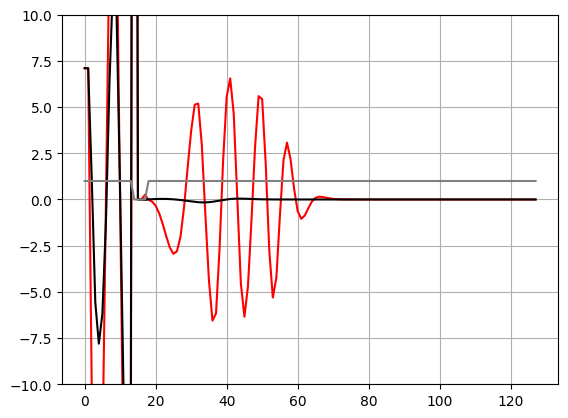

In [ ]:
# 특정 프레임의 결과를 그래프로 확인합니다.
framenum = 2000//advance # 확인할 프레임 번호 (2000 스텝에 해당하는 프레임)

# 그래프 설정
plt.grid() # 그리드 표시
plt.ylim(-10,10) # y축 범위 설정
# 중앙 행(r1)의 파동 변위를 빨간색으로 플롯합니다.
plt.plot(maps[framenum, r1, :], color='red')
# 상단 일부 행(r2)의 파동 변위를 검은색으로 플롯합니다.
plt.plot(maps[framenum, rs//16, :], color='black')
# 중앙 행의 매질 속력을 회색으로 플롯합니다. (참고용)
plt.plot(mc[r1]/(speed), color='gray')

In [ ]:
# 애니메이션의 각 프레임을 그리는 함수를 정의합니다.
def frame(k):
  # 이전 프레임의 내용을 지웁니다.
  ax[1].cla()
  ax[0].cla()
  # 첫 번째 서브플롯 (왼쪽) 설정
  plt.subplot(121)
  ax[0].set_xlabel("x (cm)")
  ax[0].set_ylabel("y (cm)")
  ax[0].set_title(f"freq = {freq:.0f} (Hz)") # 주파수 제목에 표시
  ax[0].axhline(r1, color='red', alpha=0.3) # 표본 행 1 위치 표시
  ax[0].axhline(r2, color='k', alpha=0.3) # 표본 행 2 위치 표시
  ax[0].imshow(maps[k], vmin=-5,vmax=5) # 현재 프레임의 파동 상태를 이미지로 표시

  # 격벽을 그립니다.
  draw_barrier(ax[0],lw=2)

  # 두 번째 서브플롯 (오른쪽) 설정
  plt.subplot(122)
  ax[1].set_ylim([-10,10]) # y축 범위 설정
  ax[1].grid() # 그리드 표시
  ax[1].set_xlabel("x (cm)")
  ax[1].set_ylabel("wave displacement [arbitrary unit]")
  ax[1].set_title(f"time = {ts[k]:.3e} (s)") # 현재 시간 제목에 표시
  ax[1].plot(maps[k, r1, :], c='r', label='Sample 1(red)') # 표본 행 1의 파동 변위 플롯
  ax[1].plot(maps[k, r2, :], c='k', label='Sample 2(black)') # 표본 행 2의 파동 변위 플롯
  ax[1].legend(loc='lower left') # 범례 표시

  # 첫 번째 프레임일 때만 매질 속력 보조 축을 추가합니다.
  if k==0:
    ax2 = ax[1].twinx() # 보조 y축 생성
    ax2.set_ylabel('wave speed [m/s]') # 보조 y축 레이블 설정
    ax2.set_ylim([0,1000]) # 보조 y축 범위 설정
    ax2.plot(mc[r1, :], color='gray', label='wave speed(Sample1)') # 매질 속력 플롯
    ax2.legend(loc='lower right') # 보조 축 범례 표시

  # 전체 그림의 제목을 설정합니다.
  plt.suptitle("Double Slit Interference")

In [ ]:
# 저장될 이미지의 총 개수(프레임 수)를 출력합니다.
n

200

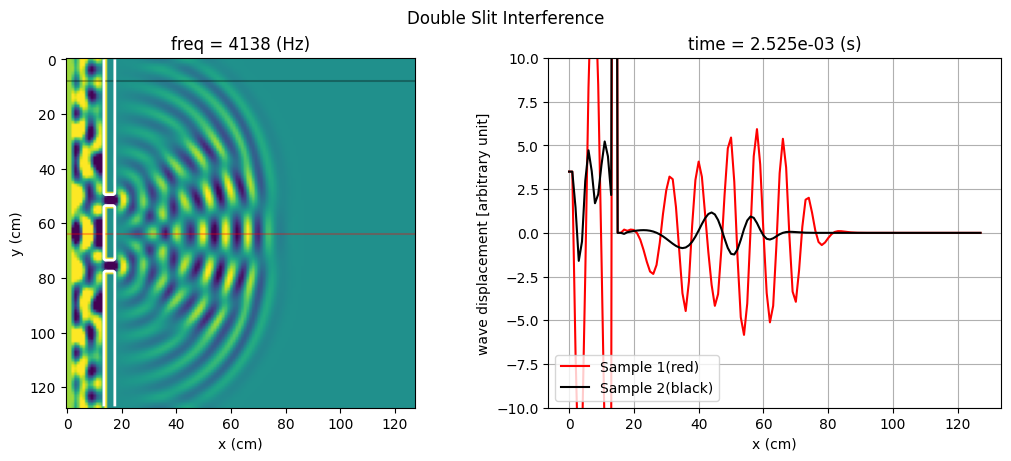

In [ ]:
# 애니메이션 프레임을 그리기 위한 그림(figure)과 축(axes)을 생성합니다.
fig, ax = plt.subplots(1,2,figsize=(10,4.5), constrained_layout=True)
# 특정 프레임 (예: 159번째 프레임)을 그려서 애니메이션이 제대로 작동하는지 확인합니다.
frame(100)

## 동영상 제작

In [ ]:
# 애니메이션 객체를 생성합니다.
# fig: 애니메이션이 그려질 그림 객체
# frame: 각 프레임을 그리는 함수
# frames: 애니메이션에 사용할 프레임 수 (n 또는 그 이하)
ani = anim.FuncAnimation(fig, frame, frames=160)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/matplotlib/animation.py", line 224, in saving
    yield self
  File "/usr/local/lib/python3.11/dist-packages/matplotlib/animation.py", line 1122, in save
    anim._draw_next_frame(d, blit=False)
  File "/usr/local/lib/python3.11/dist-packages/matplotlib/animation.py", line 1158, in _draw_next_frame
    self._post_draw(framedata, blit)
  File "/usr/local/lib/python3.11/dist-packages/matplotlib/animation.py", line 1183, in _post_draw
    self._fig.canvas.draw_idle()
  File "/usr/local/lib/python3.11/dist-packages/matplotlib/backend_bases.py", line 1891, in draw_idle
    self.draw(*args, **kwargs)
  File "/usr/local/lib/python3.11/dist-packages/matplotlib/backends/backend_agg.py", line 382, in draw
    self.figure.draw(self.renderer)
  File "/usr/local/lib/python3.11/dist-packages/matplotlib/artist.py", line 94, in draw_wrapper
    result = draw(artist, renderer, *args, **kwargs)
             ^^^^^^^^^^^^^^

TypeError: object of type 'NoneType' has no len()

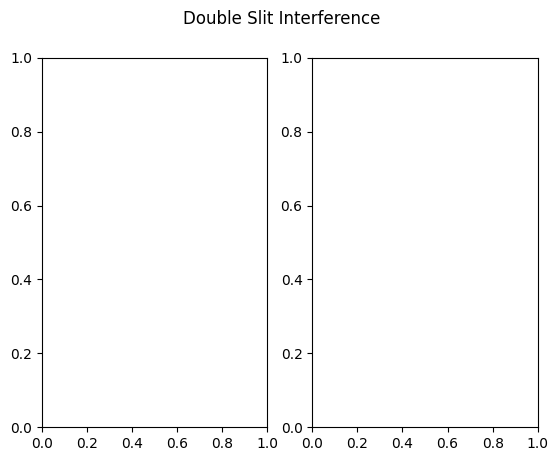

In [ ]:
# 생성된 애니메이션을 GIF 파일로 저장합니다.
# filename: 저장될 파일 이름 (주파수 값이 포함됩니다.)
# writer: 사용할 라이터 ('pillow'는 GIF 저장을 위한 라이터 중 하나)
# fps: 초당 프레임 수
fname = './wave2d-DSI_' + f'{freq:.0f}' + '.gif'
ani.save(fname, writer='pillow', fps=20)

In [ ]:
# 생성된 애니메이션을 AVI 파일로 저장합니다.
# filename: 저장될 파일 이름 (주파수 값이 포함됩니다.)
# fps: 초당 프레임 수
fname = './wave2d-DSI_' + f'{freq:.0f}' + '.avi'
ani.save(fname, fps=20)